<a href="https://colab.research.google.com/github/yankyerajoseph/yankyerajoseph/blob/main/Appendix_1_Kinetic_Modelling_of_the_AD_of_Slaughterhouse_Waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Summarised Coding


Analyzing file: /content/drive/MyDrive/SummaryofBY/RC-CGS-M.csv
Data head:


,HRT(D),Biogas Yield of RC-CGS-M (ml/g oTS)
0,0.00,0.00
1,0.63,7.28
2,0.75,14.35
3,0.88,19.86
4,1.00,25.48


Data columns: ['HRT(D)', 'Biogas Yield of RC-CGS-M (ml/g oTS)']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded RC-CGS-M_kinetic_modeling_plot_upto40days.tiff


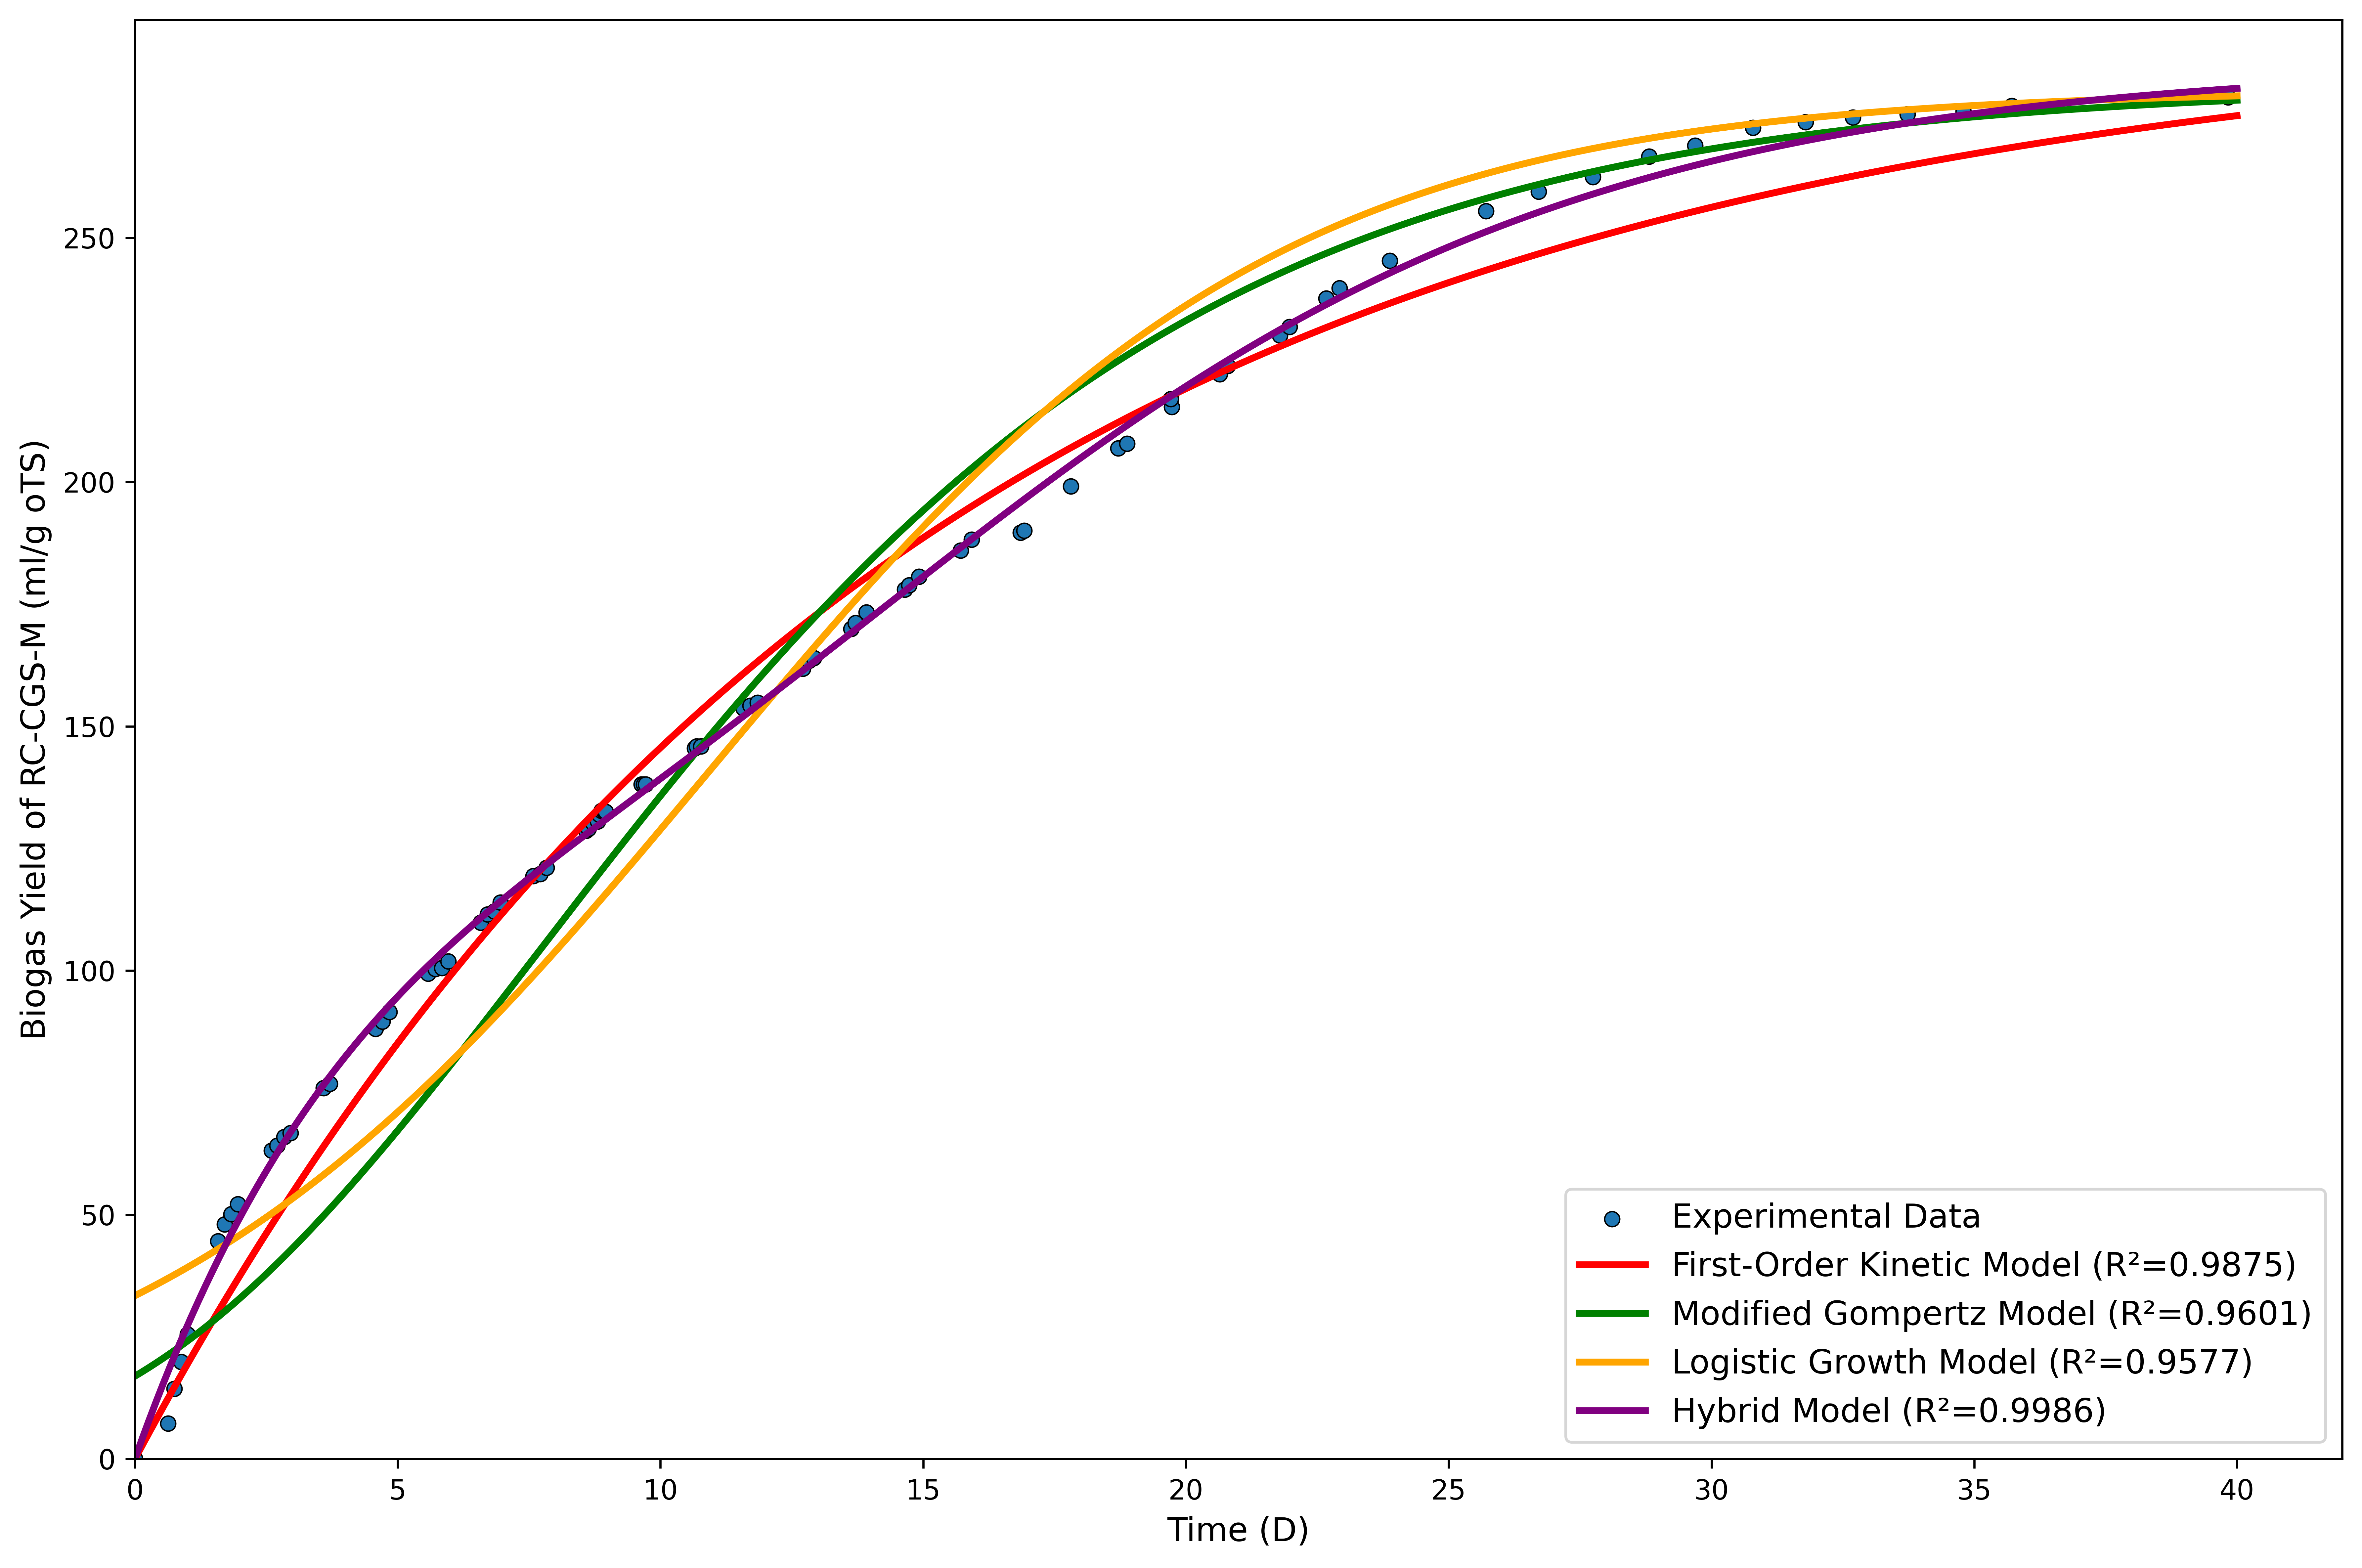


--- Summary of Kinetic Model Analysis (up to 40 Days) ---

Model Performance and Equations (up to 40 Days):


,Model,R-squared,RMSE,Equation
0,Hybrid Model,0.9986,2.7308,B(t) = 0.5 * (286.0018 * (1 - np.exp(-0.2116 *...
1,First-Order Kinetic Model,0.9875,8.2930,B(t) = 294.1375 * (1 - np.exp(-0.0683 * t))
2,Gompertz Model,0.9601,14.8116,B(t) = 281.7665 * np.exp(-np.exp((13.9726 * np...
3,Logistic Growth Model,0.9577,15.2495,B(t) = 280.3850 / (1 + np.exp((4 * 12.8832 / 2...



Model Parameters and 95% Confidence Intervals (Fit to Full Data):


,Model,Formatted Parameters,Formatted Confidence Intervals
0,Hybrid Model,"286.0018, 0.2116, 14.4554, 8.9718","(284.6743, 287.3292), (0.2044, 0.2189), (13.84..."
1,First-Order Kinetic Model,"294.1375, 0.0683","(290.8115, 297.4635), (0.0663, 0.0704)"
2,Gompertz Model,"281.7665, 13.9726, 0.2500","(276.9837, 286.5492), (13.0781, 14.8671), (-0...."
3,Logistic Growth Model,"280.3850, 12.8832, 0.0000","(275.6765, 285.0936), (12.0012, 13.7651), (-0...."



Insights (Ranked based on performance up to 40 Days):
- For the data up to 40 days, the Hybrid Model provides the best fit with R-squared of 0.9986 and RMSE of 2.7308.
- The R-squared and RMSE metrics shown here specifically evaluate the model performance on the initial 40 days of data.
- The Model Parameters and Confidence Intervals are based on fitting the models to the full dataset, as this provides a more robust estimate of the overall kinetic behavior.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import t
from google.colab import files
import os

# Define the list of file paths to process
file_paths = [
    '/content/drive/MyDrive/SummaryofBY/RC-CGS-M.csv',
    # Add other relevant file paths here if necessary
]

# Confidence interval calculation function
def get_confidence_intervals(popt, pcov, n, p):
    alpha = 0.05  # 95% confidence
    dof = max(0, n - p)
    # Avoid calculating confidence intervals if pcov contains inf or nan
    if pcov is None or not np.all(np.isfinite(pcov)):
        return [(np.nan, np.nan)] * len(popt)
    try:
        t_val = np.abs(t.ppf(alpha / 2, dof))
        perr = np.sqrt(np.diag(pcov))
        ci = []
        for i in range(len(popt)):
             # Handle potential errors in interval calculation
            try:
                lower_bound = popt[i] - t_val * perr[i]
                upper_bound = popt[i] + t_val * perr[i]
                ci.append((lower_bound, upper_bound))
            except Exception:
                ci.append((np.nan, np.nan))
        return ci
    except Exception:
        return [(np.nan, np.nan)] * len(popt)

# Define all model functions
def gompertz_model(t, B0, Rm, lambda_):
    return B0 * np.exp(-np.exp((Rm * np.e / B0) * (lambda_ - t) + 1))

def first_order_model(t, B0, k):
    # Avoid overflow in exponential
    exp_term = -k * t
    exp_term = np.clip(exp_term, -700, 700) # Clipping to avoid overflow
    return B0 * (1 - np.exp(exp_term))

def hybrid_model(t, B0, k, Rm, lambda_):
    first_order = first_order_model(t, B0, k) # Use the clipped first-order model
    gompertz = gompertz_model(t, B0, Rm, lambda_)
    return (first_order + gompertz) / 2

def logistic_growth_model(t, B0, Rm, lambda_):
    # Avoid overflow in exponential
    exp_term = (4 * Rm / B0) * (lambda_ - t) + 2
    exp_term = np.clip(exp_term, -700, 700) # Clipping to avoid overflow
    return B0 / (1 + np.exp(exp_term))


# Define the time range for plotting and analysis
plotting_time_range = 40 # Keep this for plotting as per previous discussion

# Iterate through each file path
for file_path in file_paths:
    try:
        # Load the data
        data = pd.read_csv(file_path)
        cleaned_data = data.dropna()

        # Extract data for modeling (using full data for fitting as per user feedback)
        t_data_full = cleaned_data['HRT(D)'].values
        B_data_full = cleaned_data['Biogas Yield of RC-CGS-M (ml/g oTS)'].values

        print(f"\nAnalyzing file: {file_path}")
        print("Data head:")
        display(data.head())
        print("Data columns:", data.columns.tolist())

        # Filter data for the specified plotting time range
        t_data_filtered = t_data_full[t_data_full <= plotting_time_range]
        B_data_filtered = B_data_full[t_data_full <= plotting_time_range]

        # Number of data points for confidence interval calculation (using full data for dof)
        n_full = len(B_data_full)
        n_filtered = len(B_data_filtered)


        # --- Model Fitting and Analysis (using FULL data for fitting) ---
        # Fitting is done on the full data to get the best overall parameters.
        # Metrics for the filtered data will be calculated using these parameters.

        results = {}

        # Gompertz model
        model_name = "Gompertz Model"
        try:
            popt_g, pcov_g = curve_fit(gompertz_model, t_data_full, B_data_full, bounds=(0.25, [600, 70, 70]), maxfev=10000)
            p_g = len(popt_g)
            ci_g = get_confidence_intervals(popt_g, pcov_g, n_full, p_g)
            # Calculate metrics for full data
            r_squared_g_full = r2_score(B_data_full, gompertz_model(t_data_full, *popt_g))
            rmse_g_full = np.sqrt(mean_squared_error(B_data_full, gompertz_model(t_data_full, *popt_g)))
            # Calculate metrics for filtered data (up to 40 days)
            r_squared_g_filtered = r2_score(B_data_filtered, gompertz_model(t_data_filtered, *popt_g))
            rmse_g_filtered = np.sqrt(mean_squared_error(B_data_filtered, gompertz_model(t_data_filtered, *popt_g)))

            B0_g, Rm_g, lambda_g = popt_g
            equation_g = f'B(t) = {B0_g:.4f} * np.exp(-np.exp(({Rm_g:.4f} * np.e / {B0_g:.4f}) * ({lambda_g:.4f} - t) + 1))'
            results[model_name] = {"popt": popt_g, "pcov": pcov_g, "ci": ci_g,
                                   "r_squared_full": r_squared_g_full, "rmse_full": rmse_g_full,
                                   "r_squared_filtered": r_squared_g_filtered, "rmse_filtered": rmse_g_filtered,
                                   "equation": equation_g}
        except Exception as e:
            print(f"\n{model_name} Fitting Error: {e}")
            results[model_name] = {"popt": [np.nan]*3, "pcov": None, "ci": [(np.nan, np.nan)]*3,
                                   "r_squared_full": np.nan, "rmse_full": np.nan,
                                   "r_squared_filtered": np.nan, "rmse_filtered": np.nan,
                                   "equation": "Fitting Failed"}


        # First-Order Kinetic model
        model_name = "First-Order Kinetic Model"
        try:
            popt_fo, pcov_fo = curve_fit(first_order_model, t_data_full, B_data_full, maxfev=10000)
            p_fo = len(popt_fo)
            ci_fo = get_confidence_intervals(popt_fo, pcov_fo, n_full, p_fo)
            # Calculate metrics for full data
            r_squared_fo_full = r2_score(B_data_full, first_order_model(t_data_full, *popt_fo))
            rmse_fo_full = np.sqrt(mean_squared_error(B_data_full, first_order_model(t_data_full, *popt_fo)))
            # Calculate metrics for filtered data (up to 40 days)
            r_squared_fo_filtered = r2_score(B_data_filtered, first_order_model(t_data_filtered, *popt_fo))
            rmse_fo_filtered = np.sqrt(mean_squared_error(B_data_filtered, first_order_model(t_data_filtered, *popt_fo)))

            B0_fo, k_fo = popt_fo
            equation_fo = f'B(t) = {B0_fo:.4f} * (1 - np.exp(-{k_fo:.4f} * t))'
            results[model_name] = {"popt": popt_fo, "pcov": pcov_fo, "ci": ci_fo,
                                   "r_squared_full": r_squared_fo_full, "rmse_full": rmse_fo_full,
                                   "r_squared_filtered": r_squared_fo_filtered, "rmse_filtered": rmse_fo_filtered,
                                   "equation": equation_fo}
        except Exception as e:
            print(f"\n{model_name} Fitting Error: {e}")
            results[model_name] = {"popt": [np.nan]*2, "pcov": None, "ci": [(np.nan, np.nan)]*2,
                                   "r_squared_full": np.nan, "rmse_full": np.nan,
                                   "r_squared_filtered": np.nan, "rmse_filtered": np.nan,
                                   "equation": "Fitting Failed"}


        # Hybrid model
        model_name = "Hybrid Model"
        try:
            initial_guess_hybrid = [300, 0.1, 10, 1]
            bounds_hybrid = ([0, 0, 0, 0], [450, 100, 40, 40])
            popt_h, pcov_h = curve_fit(hybrid_model, t_data_full, B_data_full, p0=initial_guess_hybrid, bounds=bounds_hybrid, maxfev=10000)
            p_h = len(popt_h)
            ci_h = get_confidence_intervals(popt_h, pcov_h, n_full, p_h)
            # Calculate metrics for full data
            r_squared_h_full = r2_score(B_data_full, hybrid_model(t_data_full, *popt_h))
            rmse_h_full = np.sqrt(mean_squared_error(B_data_full, hybrid_model(t_data_full, *popt_h)))
            # Calculate metrics for filtered data (up to 40 days)
            r_squared_h_filtered = r2_score(B_data_filtered, hybrid_model(t_data_filtered, *popt_h))
            rmse_h_filtered = np.sqrt(mean_squared_error(B_data_filtered, hybrid_model(t_data_filtered, *popt_h)))

            B0_h, k_h, Rm_h, lambda_h = popt_h
            equation_h = f'B(t) = 0.5 * ({B0_h:.4f} * (1 - np.exp(-{k_h:.4f} * t)) + {B0_h:.4f} * np.exp(-np.exp(({Rm_h:.4f} * np.e / {B0_h:.4f}) * ({lambda_h:.4f} - t) + 1)))'
            results[model_name] = {"popt": popt_h, "pcov": pcov_h, "ci": ci_h,
                                   "r_squared_full": r_squared_h_full, "rmse_full": rmse_h_full,
                                   "r_squared_filtered": r_squared_h_filtered, "rmse_filtered": rmse_h_filtered,
                                   "equation": equation_h}
        except Exception as e:
            print(f"\n{model_name} Fitting Error: {e}")
            results[model_name] = {"popt": [np.nan]*4, "pcov": None, "ci": [(np.nan, np.nan)]*4,
                                   "r_squared_full": np.nan, "rmse_full": np.nan,
                                   "r_squared_filtered": np.nan, "rmse_filtered": np.nan,
                                   "equation": "Fitting Failed"}

        # Logistic Growth model
        model_name = "Logistic Growth Model"
        try:
            popt_l, pcov_l = curve_fit(logistic_growth_model, t_data_full, B_data_full, bounds=(0, [300, 70, 7]), maxfev=10000)
            p_l = len(popt_l)
            ci_l = get_confidence_intervals(popt_l, pcov_l, n_full, p_l)
            # Calculate metrics for full data
            r_squared_l_full = r2_score(B_data_full, logistic_growth_model(t_data_full, *popt_l))
            rmse_l_full = np.sqrt(mean_squared_error(B_data_full, logistic_growth_model(t_data_full, *popt_l)))
            # Calculate metrics for filtered data (up to 40 days)
            r_squared_l_filtered = r2_score(B_data_filtered, logistic_growth_model(t_data_filtered, *popt_l))
            rmse_l_filtered = np.sqrt(mean_squared_error(B_data_filtered, logistic_growth_model(t_data_filtered, *popt_l)))

            B0_l, Rm_l, lambda_l = popt_l
            equation_l = f'B(t) = {B0_l:.4f} / (1 + np.exp((4 * {Rm_l:.4f} / {B0_l:.4f}) * ({lambda_l:.4f} - t) + 2))'
            results[model_name] = {"popt": popt_l, "pcov": pcov_l, "ci": ci_l,
                                   "r_squared_full": r_squared_l_full, "rmse_full": rmse_l_full,
                                   "r_squared_filtered": r_squared_l_filtered, "rmse_filtered": rmse_l_filtered,
                                   "equation": equation_l}
        except Exception as e:
            print(f"\n{model_name} Fitting Error: {e}")
            results[model_name] = {"popt": [np.nan]*3, "pcov": None, "ci": [(np.nan, np.nan)]*3,
                                   "r_squared_full": np.nan, "rmse_full": np.nan,
                                   "r_squared_filtered": np.nan, "rmse_filtered": np.nan,
                                   "equation": "Fitting Failed"}


        # --- Plotting (using filtered data for range, full data parameters for curves) ---

        # Generate predictions for plotting over the filtered time range
        t_pred_plot = np.linspace(0, plotting_time_range, 300)

        B_pred_gompertz_plot = gompertz_model(t_pred_plot, *results["Gompertz Model"]["popt"]) if not np.any(np.isnan(results["Gompertz Model"]["popt"])) else np.full_like(t_pred_plot, np.nan)
        B_pred_first_order_plot = first_order_model(t_pred_plot, *results["First-Order Kinetic Model"]["popt"]) if not np.any(np.isnan(results["First-Order Kinetic Model"]["popt"])) else np.full_like(t_pred_plot, np.nan)
        B_pred_hybrid_plot = hybrid_model(t_pred_plot, *results["Hybrid Model"]["popt"]) if not np.any(np.isnan(results["Hybrid Model"]["popt"])) else np.full_like(t_pred_plot, np.nan)
        B_pred_logistic_plot = logistic_growth_model(t_pred_plot, *results["Logistic Growth Model"]["popt"]) if not np.any(np.isnan(results["Logistic Growth Model"]["popt"])) else np.full_like(t_pred_plot, np.nan)


        # Create the plot
        plt.figure(figsize=(12, 8), dpi=600)

        # Plot experimental data filtered for the plotting range
        plt.scatter(t_data_filtered, B_data_filtered, label='Experimental Data', s=30, edgecolors='black', linewidths=0.5)

        # Plot fitted curves if fit was successful (using full data parameters) and label with filtered R-squared
        if not np.any(np.isnan(B_pred_first_order_plot)):
            plt.plot(t_pred_plot, B_pred_first_order_plot, label=f'First-Order Kinetic Model (R²={results["First-Order Kinetic Model"]["r_squared_filtered"]:.4f})', color='red', linewidth=2.5)
        if not np.any(np.isnan(B_pred_gompertz_plot)):
            plt.plot(t_pred_plot, B_pred_gompertz_plot, label=f'Modified Gompertz Model (R²={results["Gompertz Model"]["r_squared_filtered"]:.4f})', color='green', linewidth=2.5)
        if not np.any(np.isnan(B_pred_logistic_plot)):
            plt.plot(t_pred_plot, B_pred_logistic_plot, label=f'Logistic Growth Model (R²={results["Logistic Growth Model"]["r_squared_filtered"]:.4f})', color='orange', linewidth=2.5)
        if not np.any(np.isnan(B_pred_hybrid_plot)):
            plt.plot(t_pred_plot, B_pred_hybrid_plot, label=f'Hybrid Model (R²={results["Hybrid Model"]["r_squared_filtered"]:.4f})', color='purple', linewidth=2.5)


        # Add labels and legend
        plt.xlabel('Time (D)', fontsize=12, fontname='Times New Roman')
        plt.ylabel('Biogas Yield of RC-CGS-M (ml/g oTS)', fontsize=12, fontname='Times New Roman')
        plt.legend(loc='lower right', fontsize=12)

        # Set axis limits to include the origin
        plt.xlim(left=0)
        plt.ylim(bottom=0)

        # Ensure no grid and no title
        plt.grid(False)
        plt.title('')

        plt.tight_layout()

        # Save the figure as a high-resolution TIFF
        filename = os.path.splitext(os.path.basename(file_path))[0] + f'_kinetic_modeling_plot_upto{plotting_time_range}days.tiff'
        plt.savefig(filename, dpi=600, bbox_inches='tight', format='tiff')

        # Automatically download the file
        try:
            files.download(filename)
            print(f"Downloaded {filename}")
        except Exception as e:
            print(f"Could not automatically download {filename}. It is saved in the Colab environment.")

        # Display the plot
        plt.show()


        # --- Summary Table ---
        print("\n--- Summary of Kinetic Model Analysis (up to 40 Days) ---")

        summary_data = []
        for model_name, metrics in results.items():
            summary_data.append({
                "Model": model_name,
                "R-squared": f"{metrics['r_squared_filtered']:.4f}" if pd.notna(metrics['r_squared_filtered']) else "NaN",
                "RMSE": f"{metrics['rmse_filtered']:.4f}" if pd.notna(metrics['rmse_filtered']) else "NaN",
                "Equation": metrics["equation"],
                "Parameters (Full Data Fit)": metrics["popt"], # Keep parameters from full data fit
                "Confidence Intervals (Full Data Fit)": metrics["ci"] # Keep CIs from full data fit
            })

        summary_df = pd.DataFrame(summary_data)

        # Rank models based on R-squared (descending) and RMSE (ascending) for the *filtered* data (up to 40 days)
        summary_df_sorted = summary_df.copy()
        summary_df_sorted['R-squared_numeric'] = pd.to_numeric(summary_df_sorted['R-squared'], errors='coerce')
        summary_df_sorted['RMSE_numeric'] = pd.to_numeric(summary_df_sorted['RMSE'], errors='coerce')


        summary_df_ranked_filtered = summary_df_sorted.sort_values(
            by=['R-squared_numeric', 'RMSE_numeric'],
            ascending=[False, True]
        ).reset_index(drop=True)


        print("\nModel Performance and Equations (up to 40 Days):")
        # Use pandas formatting for display
        with pd.option_context('display.precision', 4):
             display(summary_df_ranked_filtered[['Model', 'R-squared', 'RMSE', 'Equation']])

        print("\nModel Parameters and 95% Confidence Intervals (Fit to Full Data):")
        # Format confidence intervals for better display
        def format_ci(ci_list):
            if not ci_list:
                return "N/A"
            formatted_ci = []
            for ci in ci_list:
                if np.isnan(ci[0]) or np.isnan(ci[1]):
                    formatted_ci.append("(NaN, NaN)")
                else:
                    formatted_ci.append(f"({ci[0]:.4f}, {ci[1]:.4f})") # Format to 4 decimal places
            return ", ".join(formatted_ci)

        summary_df_ranked_filtered['Formatted Confidence Intervals'] = summary_df_ranked_filtered['Confidence Intervals (Full Data Fit)'].apply(format_ci)

        # Format parameters to 4 decimal places for display
        def format_params(param_list):
             if not isinstance(param_list, np.ndarray):
                 return param_list
             return ", ".join([f"{p:.4f}" if pd.notna(p) else "NaN" for p in param_list])

        summary_df_ranked_filtered['Formatted Parameters'] = summary_df_ranked_filtered['Parameters (Full Data Fit)'].apply(format_params)

        display(summary_df_ranked_filtered[['Model', 'Formatted Parameters', 'Formatted Confidence Intervals']])

        print("\nInsights (Ranked based on performance up to 40 Days):")
        if not summary_df_ranked_filtered.empty and pd.notna(summary_df_ranked_filtered.iloc[0]['R-squared_numeric']):
             print(f"- For the data up to 40 days, the {summary_df_ranked_filtered.iloc[0]['Model']} provides the best fit with R-squared of {summary_df_ranked_filtered.iloc[0]['R-squared']} and RMSE of {summary_df_ranked_filtered.iloc[0]['RMSE']}.")
        else:
            print("- Model fitting did not succeed for any model on the filtered dataset (up to 40 days).")
        print("- The R-squared and RMSE metrics shown here specifically evaluate the model performance on the initial 40 days of data.")
        print("- The Model Parameters and Confidence Intervals are based on fitting the models to the full dataset, as this provides a more robust estimate of the overall kinetic behavior.")


    except Exception as e:
        print(f"Error processing file {file_path}: {e}")